In this notebook we show the implementation of various XAI methods presented in the module 

# LIME 

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=288de8427f3c0a5cd895dde91867f824a506d52a4654fcfd968ff3a2f79fc4f3
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


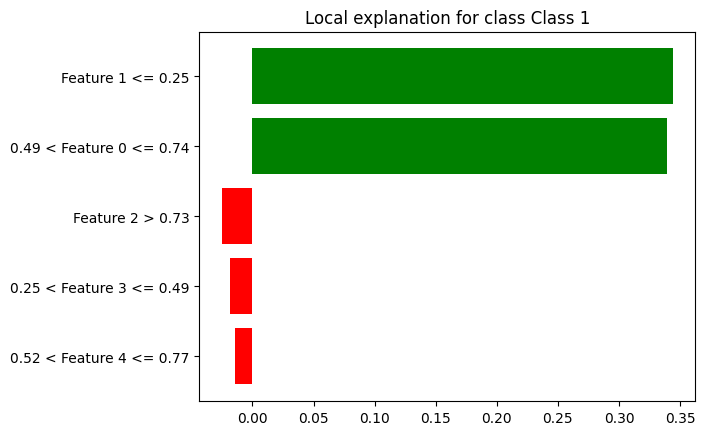

In [ ]:
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Define a function to create a fake dataset for classification
def create_dataset(n_samples):
    np.random.seed(0)
    X = np.random.rand(n_samples, 5)
    y = np.zeros(n_samples)
    y[X[:, 0] > 0.5] = 1
    y[X[:, 1] > 0.5] = 2
    return X, y

# Create a fake dataset for classification
X, y = create_dataset(1000)

# Train a random forest classifier on the dataset
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

# Define a function to predict the output of the model
def predict_fn(X):
    return clf.predict_proba(X)

# Create an explainer using LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=['Feature {}'.format(i) for i in range(5)], class_names=['Class 0', 'Class 1', 'Class 2'], discretize_continuous=True)

# Select a random data point to explain
idx = np.random.randint(0, len(X))
x_to_explain = X[idx]

# Explain the output of the model for the selected data point using LIME
exp = explainer.explain_instance(x_to_explain, predict_fn, num_features=5)

# Visualize the explanation using a bar chart
fig = exp.as_pyplot_figure()
plt.show(fig)


In [ ]:
import lime
import lime.lime_image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries


In [ ]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


In [ ]:
model = ResNet50(weights='imagenet')
img = preprocess_image('5.jpg')
explainer = lime.lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img[0], model.predict, top_labels=1, 
                                              hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


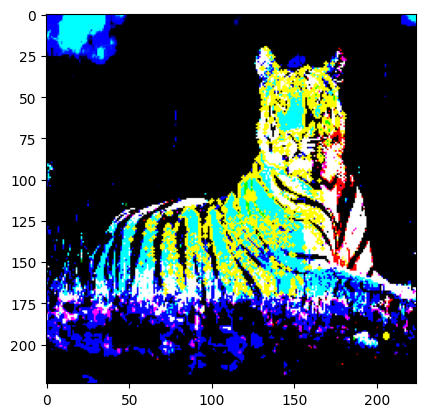

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.savefig("5.png")
plt.show()


# **SHAP**

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 25.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess input data
x_train = x_train.reshape((60000, 28, 28, 1)) / 255.0
x_test = x_test.reshape((10000, 28, 28, 1)) / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# Define the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

# Save the model
model.save('mnist_model.h5')


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 64s 33ms/step - loss: 0.2173 - accuracy: 0.9393 - val_loss: 0.0876 - val_accuracy: 0.9738
Epoch 2/5
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0804 - accuracy: 0.9768 - val_loss: 0.0641 - val_accuracy: 0.9788
Epoch 3/5
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0610 - accuracy: 0.9822 - val_loss: 0.0644 - val_accuracy: 0.9784
Epoch 4/5
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0499 - accuracy: 0.9851 - val_loss: 0.0577 - val_accuracy: 0.9818
Epoch 5/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0421 - accuracy: 0.9872 - val_loss: 0.0568 - val_accuracy: 0.9824


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import shap
import matplotlib.pyplot as plt

# Load the saved model
model = keras.models.load_model('mnist_model.h5')



In [ ]:
import shap
import tensorflow as tf
from tensorflow import keras

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension to input data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Load the pre-trained model
model = keras.models.load_model('mnist_model.h5')


In [ ]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
count=0
# Select the digit you want to count
i=0
while (i<10):
  digit = i

  # Count the number of images with the selected digit
  count = sum(1 for label in y_train if label == digit)

  # Print the count
  print("The count of digit", digit, "is:", count)
  i=i+1
  count=count+1
print(count)

The count of digit 0 is: 5923
The count of digit 1 is: 6742
The count of digit 2 is: 5958
The count of digit 3 is: 6131
The count of digit 4 is: 5842
The count of digit 5 is: 5421
The count of digit 6 is: 5918
The count of digit 7 is: 6265
The count of digit 8 is: 5851
The count of digit 9 is: 5949
5950


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


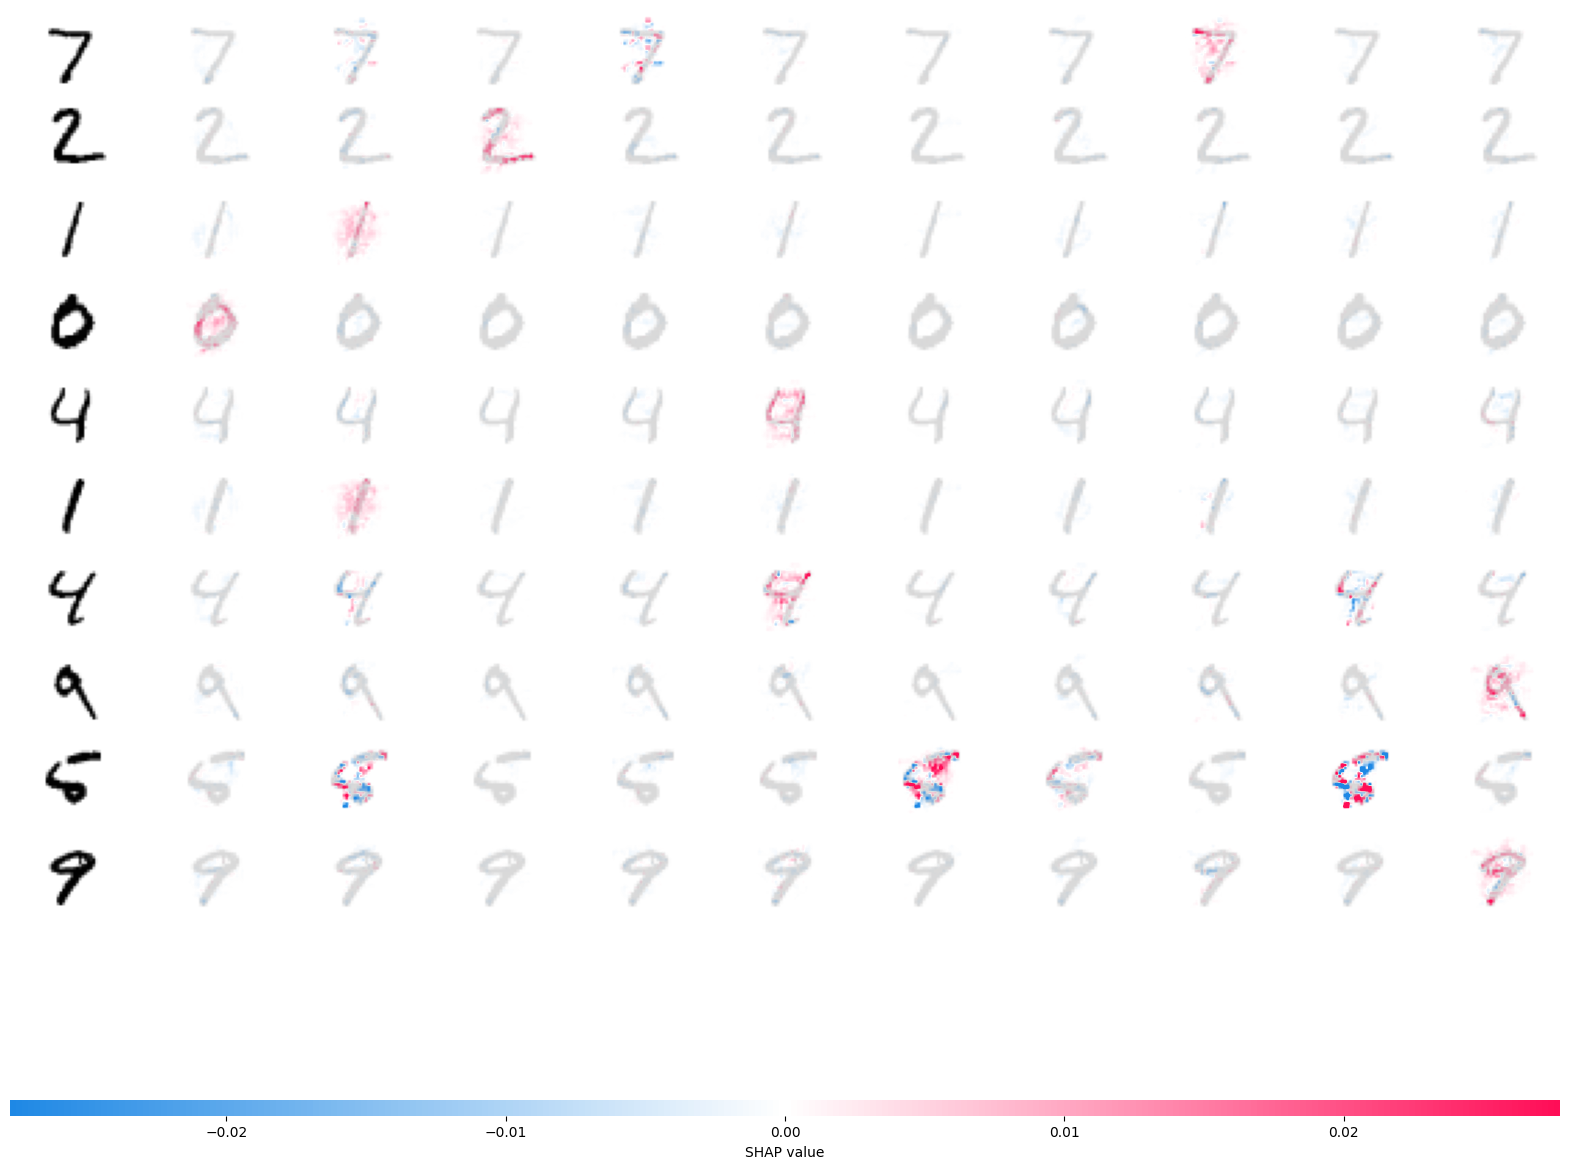

In [ ]:
# Use SHAP to explain the model's predictions
explainer = shap.DeepExplainer(model, x_train[:100])
shap_values = explainer.shap_values(x_test[:10])

shap.image_plot(shap_values, -x_test[:10])

In [ ]:
print(shap_values[0].shape)
print(x_test_reshaped[:1].shape)
print(shap.__version__)

(10, 784)
(1, 28, 28)
0.41.0


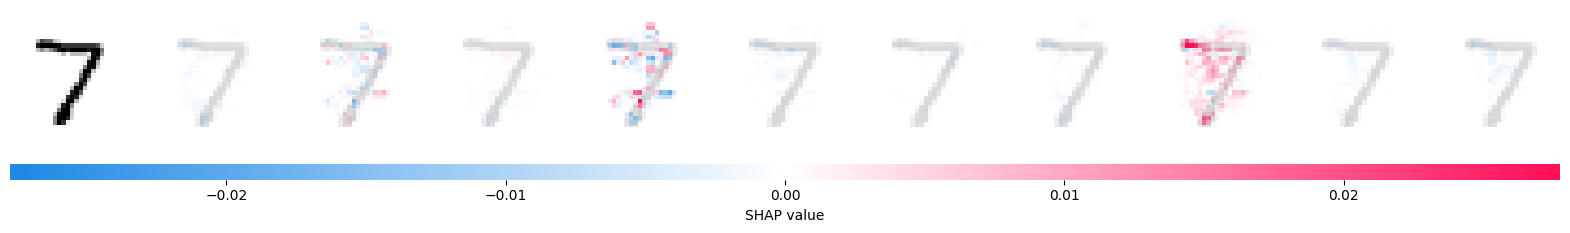

In [ ]:
import traceback

try:
    # Code that's causing the error
    shap.image_plot(shap_values, -x_test[:1])
except Exception as e:
    # Print out full traceback
    traceback.print_exc()

#Another Example for SHAP

In [ ]:
import shap
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)




RandomForestClassifier(random_state=42)

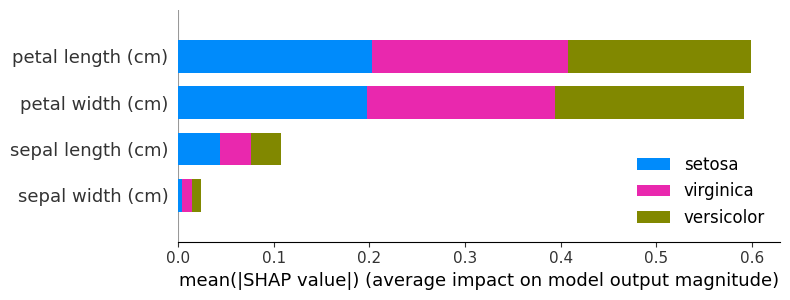

In [ ]:
# Calculate the SHAP values for the test set
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=iris.feature_names, class_names=iris.target_names)

In [ ]:
# Visualize the SHAP values for an individual instance
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test[1], feature_names=iris.feature_names)


In [61]:
# Generate a force plot for a single instance
shap.initjs()
idx = 0 # index of the instance to explain
shap.force_plot(explainer.expected_value[0], shap_values[idx], feature_names=iris.feature_names, show=True)

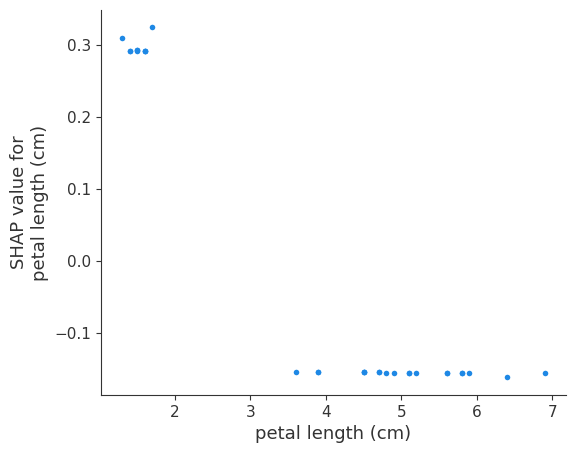

In [62]:
# Generate a dependence plot
shap.dependence_plot('petal length (cm)', shap_values[0], X_test, interaction_index=None, feature_names=iris.feature_names)


# **Counterfactual explanations**

In [ ]:
!pip install alibi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.7/522.7 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.8 MB/s eta 0:00:00


In [ ]:
from alibi.explainers import CounterFactual

In [ ]:
import numpy as np
import joblib
from sklearn.tree import DecisionTreeClassifier

# Define the training data
X_train = np.array([[30000, 580], [40000, 550], [50000, 600], [60000, 650]])
y_train = np.array([0, 0, 1, 1])

# Train a decision tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Save the model as a joblib file
joblib.dump(model, 'loan_approval_model.joblib')


['loan_approval_model.joblib']

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


In [ ]:
import numpy as np
import joblib
from alibi.explainers import Counterfactual
#from cfel import Counterfactual

# Load the trained model
model = joblib.load('loan_approval_model.joblib')

# Define the predict function for the model
def predict_fn(X):
    return model.predict_proba(X)

# Define the input data and the desired output
input_data = np.array([[50000, 600]])
desired_output = 1

# Create a counterfactual explainer object
explainer = Counterfactual(predict_fn, shape=input_data.shape, 
                           target_class=desired_output)

# Generate counterfactual explanations for the loan application rejection
explanation = explainer.explain(input_data)

# Print the counterfactual explanation
print("Counterfactual explanation:")
print(explanation)


Counterfactual explanation:
Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 2),
              'distance_fn': 'l1',
              'target_proba': 1.0,
              'target_class': 1,
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.1,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.1'}
, data={
  'cf': {
          'X': array([[50000.,   600.]], dtype=float32),
          'distance': 0.0,
          'lambda': 0.055,
          'index': 0,
          'class': 1,
          'proba': array([[0., 1.]]),
     

# **Permutation feature importance**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Load the California Housing dataset
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target

# Train a random forest regressor on the dataset
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)



RandomForestRegressor(random_state=42)

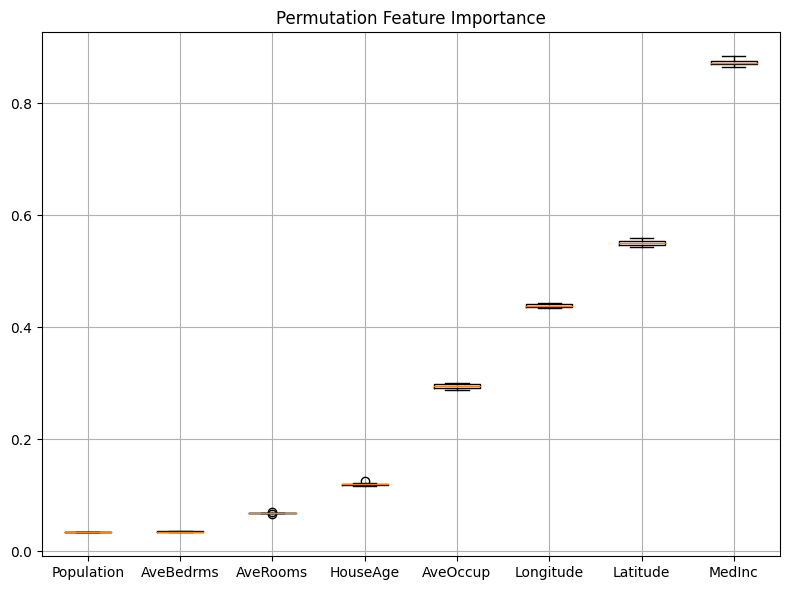

In [ ]:
# Calculate feature importances using permutation importance
result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Plot feature importances
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=True, 
           labels=np.array(california_housing.feature_names)[sorted_idx])
ax.set_title("Permutation Feature Importance")
fig.tight_layout()
plt.grid()
plt.show()


# **T-SNE**

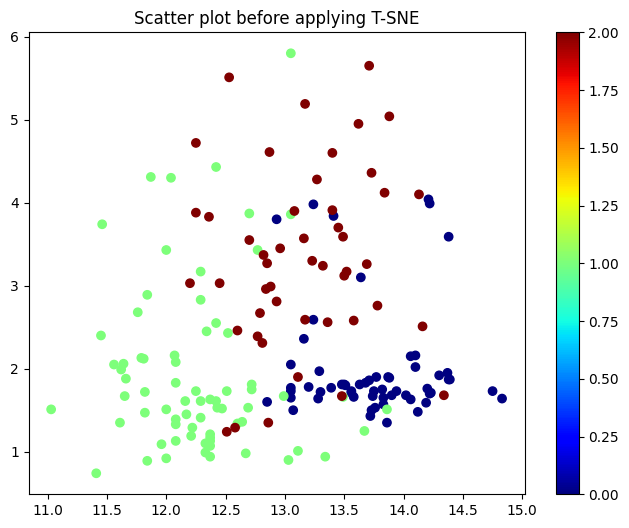

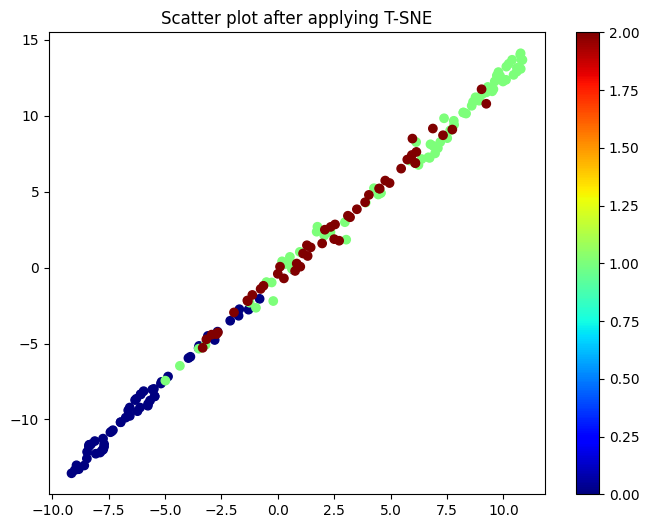

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.manifold import TSNE

# Load digits dataset
wines = load_wine()
X = wines.data
y = wines.target

# Plot scatter plot before applying T-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
plt.title('Scatter plot before applying T-SNE')
plt.colorbar()
plt.show()

# Apply T-SNE to reduce the dimensionality of the data
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot scatter plot after applying T-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='jet')
plt.title('Scatter plot after applying T-SNE')
plt.colorbar()
plt.show()


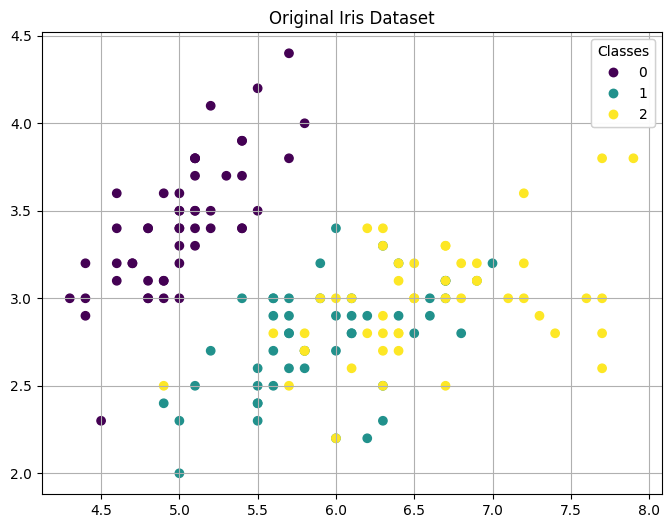

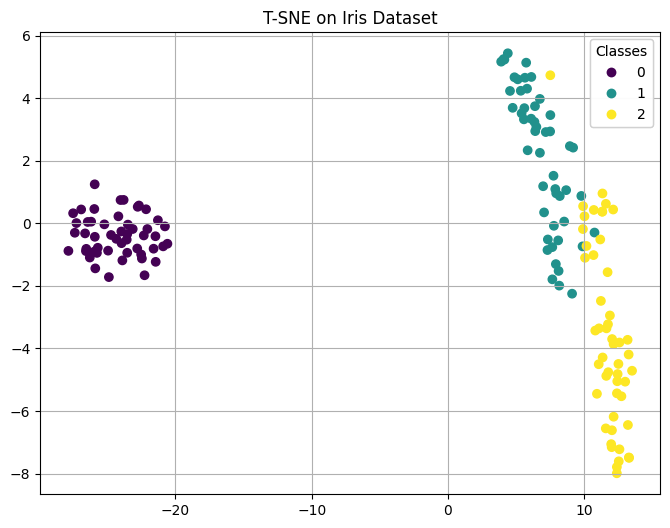

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Plot the scatter plot of the original data
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(X[:,0], X[:,1], c=y)
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.grid()
ax.set_title("Original Iris Dataset")

# Apply T-SNE on the data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the scatter plot of the T-SNE results
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
ax.set_title("T-SNE on Iris Dataset")
plt.grid()
plt.show()


# **ELI 5**

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=e72719d02276bf5d7bcdee02d34e15aa3535e31224cd39a42c77c962a25731d7
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


In [ ]:
import eli5
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the iris dataset
iris = load_iris()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                              test_size=0.2, random_state=42)

# Create a logistic regression model
clf = LogisticRegression()

# Train the model on the training set
clf.fit(X_train, y_train)

# Use ELI5 to explain the model's decision-making process
eli5.show_weights(clf, feature_names=iris.feature_names,
                                               target_names=iris.target_names)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# **R-Squared**

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load the Diabetes dataset
diabetes = load_diabetes()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, 
                              diabetes.target, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on testing data
y_pred = model.predict(X_test)

# Calculate R-squared score on testing data
r2 = r2_score(y_test, y_pred)

# Print the R-squared score
print("R-squared score:", r2)


R-squared score: 0.4526027629719195


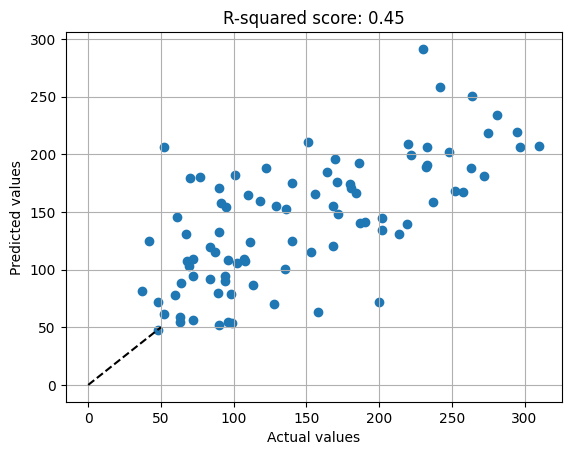

In [ ]:
import matplotlib.pyplot as plt
# Plot predicted values against actual values
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], '--k')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('R-squared score: {:.2f}'.format(r2))
plt.grid()
plt.savefig("rsqaure.png")
plt.show()

# **Sensitivity Analysis**

In [ ]:
!pip install SALib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the Boston Housing dataset
housing = fetch_california_housing()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(housing.data, 
                                housing.target, test_size=0.2, random_state=42)

# Train a random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Define the problem for sensitivity analysis
problem = {
    'num_vars': X_train.shape[1],
    'names': housing.feature_names,
    'bounds': [[X_train[:, i].min(), X_train[:, i].max()] for i in range(X_train.shape[1])]
}

# Generate samples using Saltelli sampling
N = 1000
samples = saltelli.sample(problem, N)

# Evaluate the model for each sample
Y = model.predict(samples)

# Perform Sobol sensitivity analysis
Si = sobol.analyze(problem, Y, print_to_console=False)




`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`

        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        


FixedFormatter should only be used together with FixedLocator


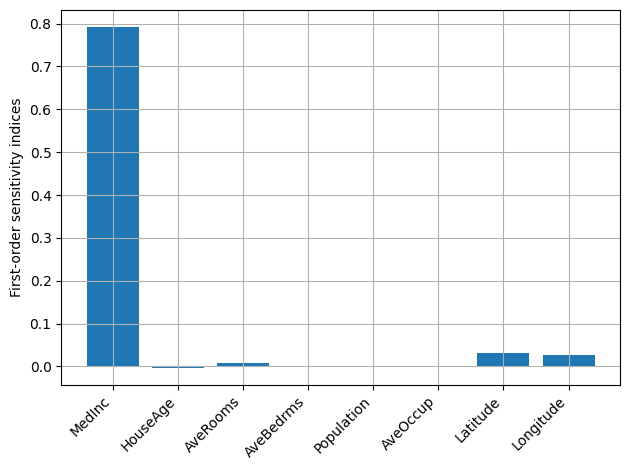

FixedFormatter should only be used together with FixedLocator


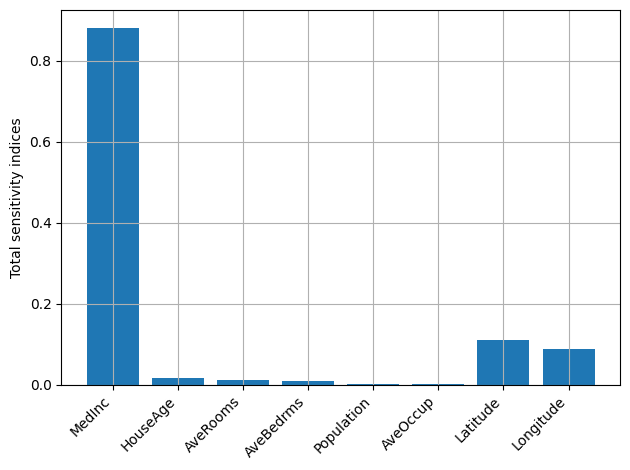

In [ ]:
import matplotlib.pyplot as plt

# Plot the first-order sensitivity indices
fig, ax = plt.subplots()
ax.bar(problem['names'], Si['S1'])
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_ylabel('First-order sensitivity indices')
plt.grid()
plt.tight_layout()
plt.savefig("1.png")
plt.show()

# Plot the total sensitivity indices
fig, ax = plt.subplots()
ax.bar(problem['names'], Si['ST'])
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_ylabel('Total sensitivity indices')
plt.grid()
plt.tight_layout()
plt.savefig("12.png")
plt.show()


In [ ]:
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the Diabetes dataset
diabetes = load_diabetes()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.2, random_state=42)

# Train a random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Define the problem for sensitivity analysis
problem = {
    'num_vars': X_train.shape[1],
    'names': diabetes.feature_names,
    'bounds': [[X_train[:, i].min(), X_train[:, i].max()] for i in range(X_train.shape[1])]
}

# Generate samples using Saltelli sampling
N = 1000
samples = saltelli.sample(problem, N)

# Evaluate the model for each sample
Y = model.predict(samples)

# Perform Sobol sensitivity analysis
Si = sobol.analyze(problem, Y, print_to_console=False)

# Print the first-order and total sensitivity indices
print('First-order indices:', Si['S1'])
print('Total indices:', Si['ST'])


`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`

        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        


First-order indices: [ 1.27258666e-02 -2.37926756e-04  6.06704283e-01  7.53338845e-02
  1.04657692e-02  4.11403961e-03  9.99960900e-03  1.27632107e-03
  1.95766095e-01  5.53589293e-03]
Total indices: [0.02262872 0.00238427 0.66445864 0.09226161 0.01674711 0.03208692
 0.01390504 0.00866861 0.24730538 0.02533132]


FixedFormatter should only be used together with FixedLocator


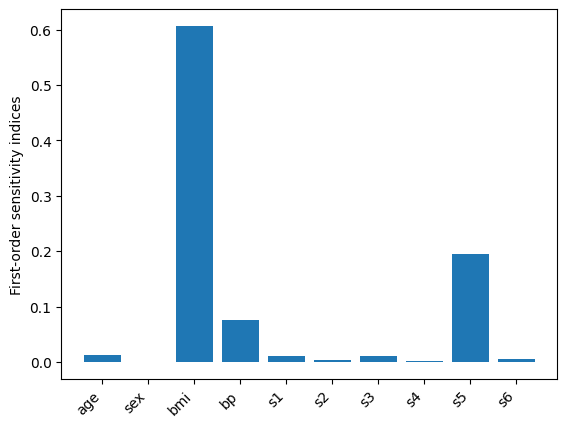

FixedFormatter should only be used together with FixedLocator


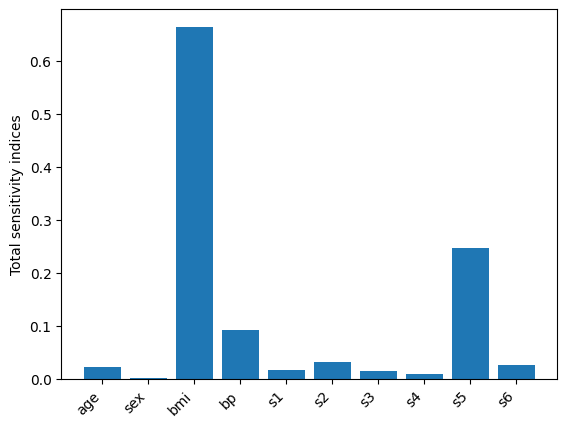

In [ ]:
import matplotlib.pyplot as plt

# Plot the first-order sensitivity indices
fig, ax = plt.subplots()
ax.bar(problem['names'], Si['S1'])
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_ylabel('First-order sensitivity indices')
plt.show()

# Plot the total sensitivity indices
fig, ax = plt.subplots()
ax.bar(problem['names'], Si['ST'])
ax.set_xticklabels(problem['names'], rotation=45, ha='right')
ax.set_ylabel('Total sensitivity indices')
plt.show()


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

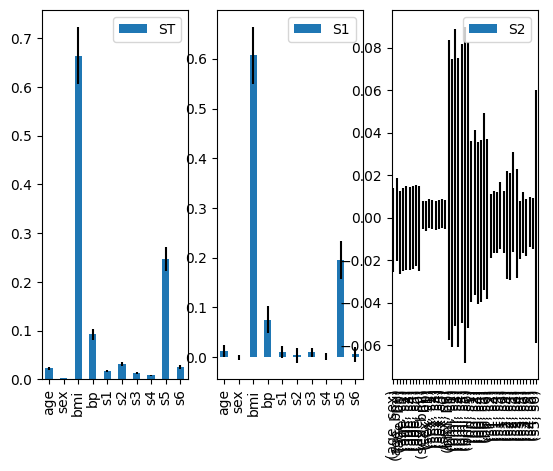

In [ ]:
Si.plot()

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

# Run model (example)
Y = Ishigami.evaluate(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=True)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

          ST   ST_conf
x1  0.555860  0.077402
x2  0.441898  0.038844
x3  0.244675  0.027237
          S1   S1_conf
x1  0.316832  0.058223
x2  0.443763  0.057741
x3  0.012203  0.061467
                S2   S2_conf
(x1, x2)  0.009254  0.080446
(x1, x3)  0.238172  0.107482
(x2, x3) -0.004888  0.065067


`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

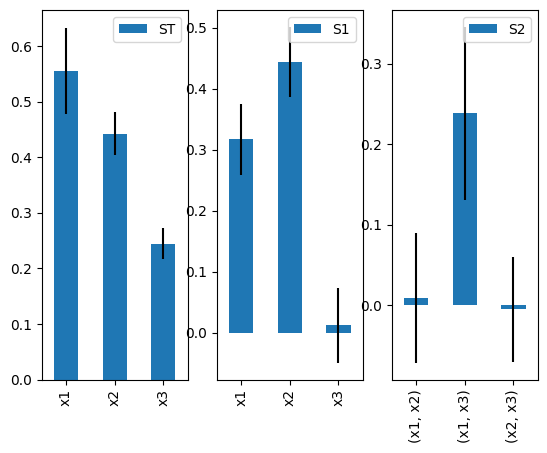

In [ ]:
Si.plot()

          ST   ST_conf
x1  0.555860  0.077952
x2  0.441898  0.040452
x3  0.244675  0.027192
          S1   S1_conf
x1  0.316832  0.071942
x2  0.443763  0.052850
x3  0.012203  0.056116
                S2   S2_conf
(x1, x2)  0.009254  0.085557
(x1, x3)  0.238172  0.120191
(x2, x3) -0.004888  0.065307
Samples:
	3 parameters: ['x1', 'x2', 'x3']
	8192 evaluations 

Outputs:
	1 outputs: ['Y']
	8192 evaluations 

Analysis:
          ST   ST_conf
x1  0.555860  0.077952
x2  0.441898  0.040452
x3  0.244675  0.027192 

          S1   S1_conf
x1  0.316832  0.071942
x2  0.443763  0.052850
x3  0.012203  0.056116 

                S2   S2_conf
(x1, x2)  0.009254  0.085557
(x1, x3)  0.238172  0.120191
(x2, x3) -0.004888  0.065307 


[[-3.13238877 -0.77619428 -0.32827189]
 [-0.08283496 -0.77619428 -0.32827189]
 [-3.13238877  0.3589515  -0.32827189]
 ...
 [-0.93572828  0.80073797  0.99095159]
 [-0.93572828  0.81914574  2.70901007]
 [-0.93572828  0.81914574  0.99095159]]
[ 3.426362    3.3527401   0.85463

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

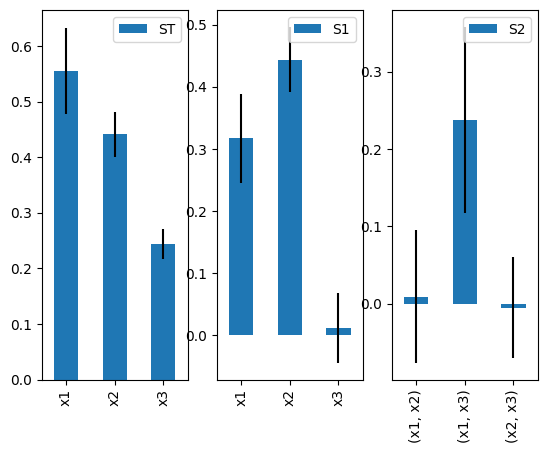

In [ ]:
from SALib import ProblemSpec
from SALib.test_functions import Ishigami

import numpy as np


# By convention, we assign to "sp" (for "SALib Problem")
sp = ProblemSpec({
  'names': ['x1', 'x2', 'x3'],   # Name of each parameter
  'bounds': [[-np.pi, np.pi]]*3,  # bounds of each parameter
  'outputs': ['Y']               # name of outputs in expected order
})

(sp.sample_saltelli(1024, calc_second_order=True)
   .evaluate(Ishigami.evaluate)
   .analyze_sobol(print_to_console=True))

print(sp)

# Samples, model results and analyses can be extracted:
print(sp.samples)
print(sp.results)
print(sp.analysis)

# Basic plotting functionality is also provided
sp.plot()

# **Layer-wise Relevant Propagation (LRP)**

In [ ]:
!pip install innvestigate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 KB 2.7 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import keras
import numpy as np
import innvestigate




In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((10000, 784))
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Define the model architecture
model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9359

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


60000/60000 [==============================] - 24s 405us/sample - loss: 0.2180 - accuracy: 0.9359 - val_loss: 0.0949 - val_accuracy: 0.9712
Epoch 2/10
60000/60000 [==============================] - 19s 318us/sample - loss: 0.0968 - accuracy: 0.9702 - val_loss: 0.0744 - val_accuracy: 0.9766
Epoch 3/10
60000/60000 [==============================] - 20s 340us/sample - loss: 0.0675 - accuracy: 0.9783 - val_loss: 0.0845 - val_accuracy: 0.9746
Epoch 4/10
60000/60000 [==============================] - 14s 239us/sample - loss: 0.0532 - accuracy: 0.9830 - val_loss: 0.0660 - val_accuracy: 0.9796
Epoch 5/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0426 - accuracy: 0.9857 - val_loss: 0.0614 - val_accuracy: 0.9808
Epoch 6/10
60000/60000 [==============================] - 12s 203us/sample - loss: 0.0350 - accuracy: 0.9884 - val_loss: 0.0643 - val_accuracy: 0.9809
Epoch 7/10
60000/60000 [==============================] - 12s 203us/sample - loss: 0.0307 - accuracy: 0.9

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Predicted class: 2


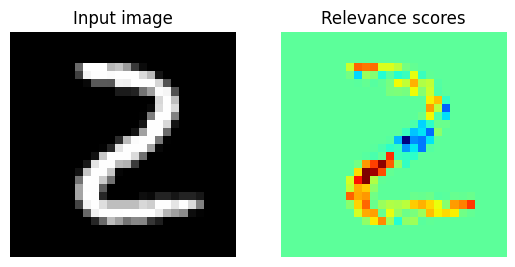

In [ ]:
# Create an analyzer for the trained model
analyzer = innvestigate.create_analyzer('lrp.epsilon', model)

# Select a random test image and get its prediction
idx = np.random.randint(len(x_test))
x = x_test[idx][np.newaxis, :]
pred = model.predict(x)[0]
print(f"Predicted class: {np.argmax(pred)}")

# Compute relevance scores using LRP
analysis = analyzer.analyze(x)

# Visualize the relevance scores and the original image
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Input image')

plt.subplot(1, 2, 2)
plt.imshow(analysis.reshape(28, 28), cmap='jet')
plt.axis('off')
plt.title('Relevance scores')

plt.show()

# **Occlusion Sensitivity**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.utils as image


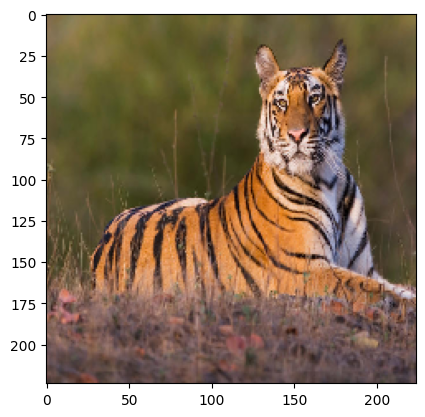

In [ ]:
# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Load the example image
img_path = '5.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = preprocess_input(x)
plt.imshow(img)




1/1 [==============================] - 0s 447ms/step


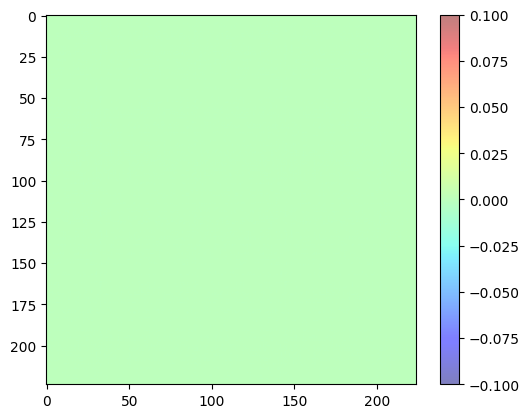

In [ ]:
# Define the occlusion size
occlusion_size = 50

# Loop through the image and perform occlusion sensitivity analysis
output_size = model.predict(x.reshape(1, 224, 224, 3)).shape[1]
occlusion_map = np.zeros((224, 224))
for i in range(0, 224, occlusion_size):
    for j in range(0, 224, occlusion_size):
        # Create the occluded image
        occluded_img = np.copy(x)
        occluded_img[i:i+occlusion_size, j:j+occlusion_size, :] = 0
        # Get the output probability for the occluded image
        output = model.predict(occluded_img.reshape(1, 224, 224, 3))
        # Calculate the difference in output probabilities between the occluded and original image
        occlusion_map[i:i+occlusion_size, j:j+occlusion_size] = output[0][np.argmax(output)] - output[0][np.argmax(model.predict(x.reshape(1, 224, 224, 3)))]

# Plot the occlusion map
plt.imshow(occlusion_map, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()